# Transformer

(RNN을 사용하지 않고, 인코더-디코더 구조를 설계하였음에도 번역 성능이 RNN보다 우수한 성능을 보여주었음)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Transformer의 주요 hyperparameter

*아래 수치는 트랜스포머를 제안한 논문에서 사용한 수치로 사용자가 모델 설계시 임의로 변경할 수 있음*
- $d_{model} = 512 $: 임베딩 벡터의 차원  (각 인코더와 디코더가 다음 층의 인코더와 디코더로 값을 보낼 때에도 이 차원을 유지)
- $\text{num_layers} = 6$: 인코더와 디코더를 층으로 생각했을 때, 트랜스포머 모델에서 인코더와 디코더가 총 몇 층으로 구성되었는지를 의미
- $\text{num_heads} = 8$: 트랜스포머에서 어텐션을 사용할 때, 한번 하는 것보다 여러 개로 분할해서 병렬로 어텐션을 수행하고 결과값을 다시 하나로 합치는 방식을 택함. 이때 이 병렬의 개수를 **num_heads**로 표현
- $d_{ff} = 2048$: 트랜스포머 내부에는 피드포워드 신경망이 존재하는데, 해당 신경망의 **은닉층 크기**를 의미 --> 신경망의 입력층과 출력층 크기는 $d_{model}$임

## Positional Encoding

트랜스포머의 입력에 대해 먼저 알아보자.

RNN이 자연어 처리에서 유용했던 이유는 단어의 위치에 따라 단어를 순차적으로 입력받아서 처리하는 RNN의 특성으로 인해 각 단어의 위치 정보(position informaition)을 가질 수 있다는 점이었음.

하지만 트랜스포머는 단어 입력을 순차적으로 받는 방식을 채택하지 않음. 따라서 단어의 위치 정보를 다른 방식으로 알려줄 필요가 있음. 트랜스포머는 단어의 위치 정보를 얻기 위해서 각 단어의 임베딩 벡터에 위치 정보들을 더하여 모델의 입력으로 사용하는데, 이를 포지셔널 인코딩(positional encoding)이라고 함

In [5]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis], # tf.newaxis를 통해 차원을 하나 추가
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :], # tf.newaxis를 통해 차원을 하나 추가
            d_model=d_model
        )

        # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        angle_rads = np.zeros(angle_rads.shape)
        angle_rads[:, 0::2] = sines
        angle_rads[:, 1::2] = cosines
        pos_encoding = tf.constant(angle_rads)
        pos_encoding = pos_encoding[tf.newaxis, ...] # ...은 :와 비슷한 용도로 사용 가

        print(pos_encoding.shape)

        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

50 x 128 크기를 갖는 포지셔널 인코딩 행렬을 시각화 해보자.  --> (입력 문장의 단어 50개, 각 단어의 차원 128차원인 임베딩 벡터)

어떤 형태를 갖고 있을까?

(1, 50, 128)


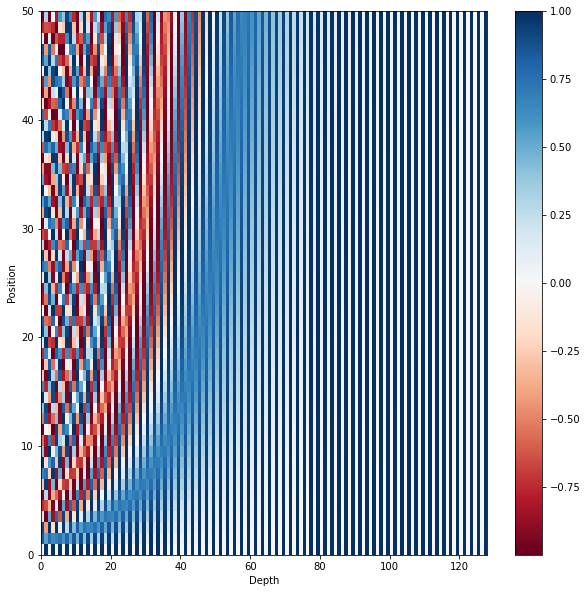

In [7]:
import matplotlib.pyplot as plt

# 문장의 길이 50, 임베딩 벡터 차원 128

sample_pos_encoding = PositionalEncoding(50, 128)  # 포지션은 총 50개. why? 단어가 50개임

plt.figure(figsize=(10, 10))
plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Attention

Transformer에서 사용되는 세 가지 어텐션에 대해 알아야 할 필요가 있음. 이 큰그림을 먼저 이해해야함

(Query, Key 등이 같다는 것은 벡터의 값이 같다는 것이 아니라 벡터의 출처가 같다는 의미)

- Encoder Self-Attention: Query = Key = Value (본질적으로 Query Key Value가 동일한 경우)
- Masked Decoder Self-Attention:  Query = Key = Value
- Encoder-Decoder Attention: Query(디코더 벡터) / Key = Value (인코더 벡터)

In [8]:
# scaled dot product attention 구현

def scaled_dot_product_attention(query, key, value, mask):
    """
    :param query: 쿼리 크기 (batch_size, num_heads, query 문장 길이, d_model / num_heads)
    :param key: 키 크기 (batch_size, num_heads, key 문장 길이, d_model / num_heads)
    :param value: 밸류 크기 (batch_size, num_heads, value 문장 길이, d_model / num_heads)
    :param mask: padding_mask 크기 (batch_size, 1, 1, key 문장 길이)
    :return:
    """

    # Attention Score Matrix : Q x KT
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # Scaling by sqrt(dk)
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # Masking -> Attention Score 행렬ㅇ서 마스킹 할 위치에 매우 작은 음수값 추가
    # 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0으로 변환
    if mask is not None:
        logits += (mask * -1e9)

    # softmax 마지막 차원인 key 문장 길이 방향으로 연산 수행
    # attention_weight : (batch_size, num_heads, query 문장 길이, key 문장 길이)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # output : (batch_size, num_heads, query 문장 길이, d_model/num_heads)
    output = tf.matmul(attention_weights, value)

    return output, attention_weights

In [9]:
# 함수 테스트
# temporary Q, K, V 행렬 생성 후 scaled_dot_product_attention 진행

np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1, 0],
                      [  10, 0],
                      [ 100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

쿼리에 해당하는 temp_q 값이 key 의 어느 부분과 일치하는지 체크 필요.

In [10]:
# 함수 실행하여 어텐션 분포 확인
temp_out, temp_attention = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_out)  # output -> 즉 어텐션 밸류
print(temp_attention)  # attention weights -> 어텐션 분포

tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)


- attention weights = (1, 4)
- values = (4, 2) 행렬
- 맷멀 결과 -> (1, 2) 행렬의 어텐션 벨류가 나옴
결과는 values (temp_v)의 두번째 행벡터 값과 같음


In [11]:
# 다른 테스트
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)

temp_out, temp_attention = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_out)
print(temp_attention)

tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)


temp_k 의 값을 살펴보고 매핑 시켜보자 -> `[0, 0, 10]` 이 두 개 있음.

또한 attention value는 [550, 5.5]는 Value의 세번째 값 [100, 5]에 0.5를 곱한 값과 네번째 값 [1000, 6]에 0.5를 곱한 값의 원소별 합임


In [12]:
# 3개 쿼리를 날려보면?

temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
temp_out, temp_attention = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_out) # 어텐션 값
print(temp_attention) # 어텐션 분포(어텐션 가중치의 나열)

tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
